In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
df = pd.read_csv('NADAC.csv')

In [3]:
print(df.shape, "\n", df.dtypes)
df.head()

(8689611, 12) 
 NDC Description                               object
NDC                                            int64
NADAC_Per_Unit                               float64
Effective_Date                                object
Pricing_Unit                                  object
Pharmacy_Type_Indicator                       object
OTC                                           object
Explanation_Code                              object
Classification_for_Rate_Setting               object
Corresponding_Generic_Drug_NADAC_Per_Unit    float64
Corresponding_Generic_Drug_Effective_Date     object
As of Date                                    object
dtype: object


,NDC Description,NDC,NADAC_Per_Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date
0,ENEMA,536741551,0.00649,03/18/2015,ML,C/I,Y,"1, 5",G,NaN,NaN,03/25/2015
1,SEBEX SHAMPOO,536196297,0.02131,03/18/2015,ML,C/I,Y,"1, 5",G,NaN,NaN,04/01/2015
2,SIMVASTATIN 80 MG TABLET,24658030410,0.07795,02/17/2016,EA,C/I,N,1,G,NaN,NaN,03/16/2016
3,LYRICA 200 MG CAPSULE,71101768,5.63640,01/01/2016,EA,C/I,N,2,B,NaN,NaN,03/16/2016
4,RABEPRAZOLE SOD DR 20 MG TAB,65162072409,0.68732,02/17/2016,EA,C/I,N,1,G,NaN,NaN,03/16/2016


In [4]:
#RX meds only
df = df[df["OTC"] == "N"]

#drop extra columns
df = df.drop(['NDC','Pharmacy_Type_Indicator', 'Classification_for_Rate_Setting', 
         'OTC', 'Explanation_Code' ], axis=1)

#A single medication dose can have multiple NDC
df = df.drop_duplicates()


#get a list of medications that have generics availible
generic_df = df[df['Corresponding_Generic_Drug_Effective_Date'].notna()]
gen_list = generic_df['NDC Description'].unique().tolist()
df = df[df['NDC Description'].isin(gen_list)]

#rename price columns
df.rename(columns={'NADAC_Per_Unit':'Brandname_Price'
                   ,'Corresponding_Generic_Drug_NADAC_Per_Unit' : 'Generic_Price'
                  }, inplace=True)
#dates
df['As of Date'] = pd.to_datetime(df['As of Date'], infer_datetime_format=True)
df['Effective_Date'] = pd.to_datetime(df['Effective_Date'], infer_datetime_format=True)
df['Corresponding_Generic_Drug_Effective_Date'] = pd.to_datetime(df['Corresponding_Generic_Drug_Effective_Date'], infer_datetime_format=True)

print(df.shape)
df.head()

(302677, 7)


,NDC Description,Brandname_Price,Effective_Date,Pricing_Unit,Generic_Price,Corresponding_Generic_Drug_Effective_Date,As of Date
3,LYRICA 200 MG CAPSULE,5.63640,2016-01-01,EA,NaN,NaT,2016-03-16
51,ZETIA 10 MG TABLET,8.35885,2016-01-07,EA,NaN,NaT,2016-03-23
69,RAPAFLO 4 MG CAPSULE,6.75516,2016-01-01,EA,NaN,NaT,2016-03-30
72,CIALIS 2.5 MG TABLET,7.58127,2015-12-01,EA,NaN,NaT,2016-03-30
75,BUTRANS 5 MCG/HR PATCH,49.54012,2015-10-01,EA,NaN,NaT,2016-03-30


In [5]:
df.to_csv("rx_meds.csv", index=False)

In [5]:
#Ratio as a brand to generic price. Numbers <1 indicate it is cheaper namebrand.
df['name/gen'] = df['Brandname_Price'] / df['Generic_Price']
#The actual difference in price.
df['name_gen_dif'] = df['Brandname_Price'] - df['Generic_Price']

In [6]:
df.describe()

,Brandname_Price,Generic_Price,name/gen,name_gen_dif
count,302677.000000,223736.000000,223736.000000,223736.000000
mean,19.009862,6.030921,33.465625,11.442747
std,42.827554,23.221827,82.419270,23.847331
min,0.003090,0.002740,0.189935,-115.105000
25%,4.273860,0.211060,1.878437,1.964700
50%,7.859110,0.820480,4.573818,5.262410
75%,15.440690,4.203960,29.380670,10.764600
max,634.659550,413.988000,1396.906529,339.373160


After reviewing the data from a year ago, I found that the span between brand and generic has increased. Generic prices haven't increased but brandname prices have.

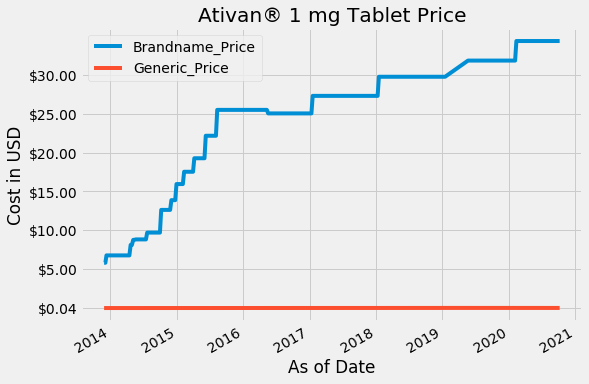

In [7]:
ativan_1mg = df[df['NDC Description'] == "ATIVAN 1 MG TABLET"]

#plotting
plt.style.use('fivethirtyeight')
ax = ativan_1mg.plot(x='As of Date'
                , y=['Brandname_Price', 'Generic_Price']
                , yticks=(.04, 5, 10, 15, 20, 25, 30)
                , figsize=(8,6))
plt.title('Ativan® 1 mg Tablet Price')
plt.ylabel('Cost in USD')
#formatting the ticks to USD
formatter = ticker.FormatStrFormatter('$%1.2f')
ax.yaxis.set_major_formatter(formatter)

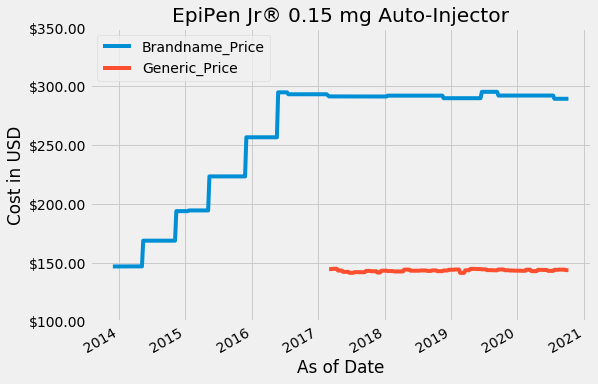

In [8]:
epipen = df[df['NDC Description'] == 'EPIPEN JR 2-PAK 0.15 MG INJCTR']

ax = epipen.plot(x='As of Date'
                , y=['Brandname_Price', 'Generic_Price']
                , ylim=[100, 350]
                , figsize=(8,6))
plt.legend(loc='upper left')
plt.title('EpiPen Jr® 0.15 mg Auto-Injector')
plt.ylabel('Cost in USD')
ax.yaxis.set_major_formatter(formatter)

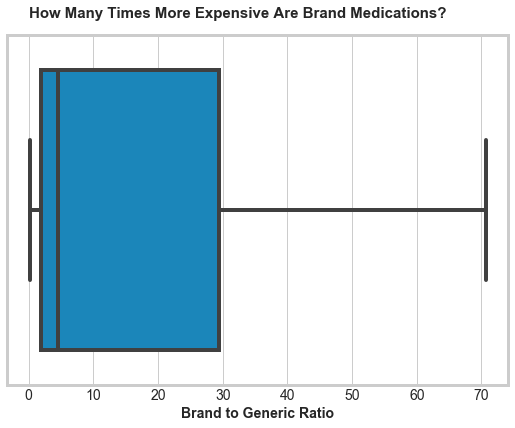

In [9]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
ax = sns.boxplot(x=df['name/gen'], showfliers=False)
ax.text(0, -.55,'How Many Times More Expensive Are Brand Medications?', fontsize=15, fontweight='bold')
plt.xlabel('Brand to Generic Ratio', fontsize=14, fontweight='bold');

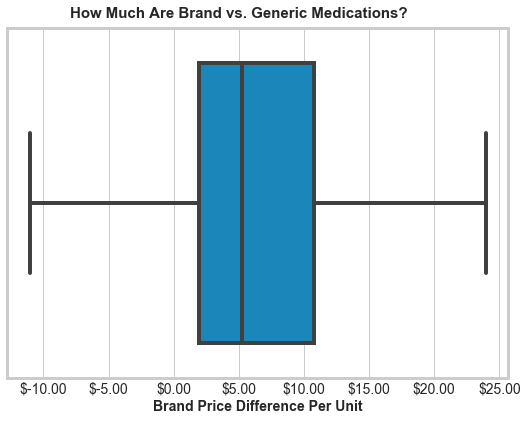

In [10]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,6))
ax = sns.boxplot(x=df['name_gen_dif'], showfliers=False)
ax.text(-8, -.53,'How Much Are Brand vs. Generic Medications?', fontsize=15, fontweight='bold')
plt.xlabel('Brand Price Difference Per Unit', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(formatter)

In [11]:
present_df = df[df["As of Date"] == "2020-10-07"]
present_df['Generic_Price'].isnull().value_counts()

False    473
True      31
Name: Generic_Price, dtype: int64

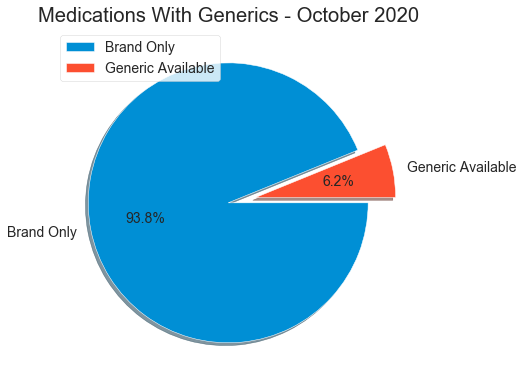

In [12]:
values = [ 473, 31]
colors = ['#008FD5', '#FC4F30']
labels = ['Brand Only', 'Generic Available']
explode = (0, 0.2)
fig = plt.figure(figsize=(8,6))
plt.pie(values, colors=colors, labels=labels,explode=explode, autopct='%1.1f%%' ,counterclock=False, shadow=True)
plt.title('Medications With Generics - October 2020')
plt.legend(labels,loc='upper left')
plt.show()